## Postprocessing outputs from 9 dimensional problem to receive final suggestions for experiments

This Notebook performs the postprocessing for the 9 dimensional problem.

As components we have the polymer PA56, phytic acid, the amino-based components (MEL, THAM, CS, BN) and the metallic-based components (ZnBO, CABO, HNT).

Here loaded from Outputs_orig folder corresponding to the results shown in the paper, but can also run Sampling_4components notebook and then load results from Outputs folder here


It contains the following steps:
1. Import all output files and format as data frames
2. LHS calculation and export to file, discrepancies and variance**
3. LHSMDU calculation and export to file, discrepancies and variance**
4. Import and format data set
5. Reduce to 2 dimensions and plot
6. Calculate other discrepancies and variance to check space filling properties/ uniformity
7. Distribution plots
8. Discrepancy for LHS and LHSMDU without constraints


written by Christina Schenk

last updated on 09/01/2025

tested on Christina's M1 Mac

#### Import Python Packages

In [1]:
import pandas as pd
import os
from pathlib import Path  
import csv
from scipy.stats import qmc
import lhsmdu
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('..')
from src.plot import *
from src.conditionedSampling import *


### **1. Import all output files and format as data frames**

In [2]:
filename_lhs_amino = "Outputs/LHS_with_new_permutations_correct_suggestions_allselected_imp_ext_subprobs_amino-based.csv"
filename_lhsmdu_amino = "Outputs/LHSMDU_with_new_permutations_correct_suggestions_allselected_imp_ext_subprobs_amino-based.csv"
filename_lhs_metallic = "Outputs/LHS_with_new_permutations_correct_suggestions_allselected_imp_ext_subprobs_metallic-based.csv"
filename_lhsmdu_metallic = "Outputs/LHSMDU_with_new_permutations_correct_suggestions_allselected_imp_ext_subprobs_metallic-based.csv"
filename_lhs = "Outputs/LHS_with_new_permutations_correct_suggestions_allselected_imp_ext_subprobs_improve.csv"
filename_lhsmdu = "Outputs/LHSMDU_with_new_permutations_correct_suggestions_allselected_imp_ext_subprobs_improve.csv"

df_lhs_amino = pd.read_csv(filename_lhs_amino)
df_lhs_amino = df_lhs_amino.loc[:, ~df_lhs_amino.columns.str.contains('^Unnamed')]
df_lhsmdu_amino = pd.read_csv(filename_lhsmdu_amino)
df_lhsmdu_amino = df_lhsmdu_amino.loc[:, ~df_lhsmdu_amino.columns.str.contains('^Unnamed')]
df_lhs_metallic = pd.read_csv(filename_lhs_metallic)
df_lhs_metallic = df_lhs_metallic.loc[:, ~df_lhs_metallic.columns.str.contains('^Unnamed')]
df_lhsmdu_metallic = pd.read_csv(filename_lhsmdu_metallic)
df_lhsmdu_metallic = df_lhsmdu_metallic.loc[:, ~df_lhsmdu_metallic.columns.str.contains('^Unnamed')]
df_lhs = pd.read_csv(filename_lhs)
df_lhs = df_lhs.loc[:, ~df_lhs.columns.str.contains('^Unnamed')]
df_lhsmdu= pd.read_csv(filename_lhsmdu)
df_lhsmdu = df_lhsmdu.loc[:, ~df_lhsmdu.columns.str.contains('^Unnamed')]


In [3]:
df_lhs.columns = ["PA56", "PhA", "amino-based", "metallic-based"]
df_lhsmdu.columns = ["PA56", "PhA", "amino-based", "metallic-based"]
df_lhs_amino.columns = ["MEL", "THAM", "CS", "BN"]
df_lhsmdu_amino.columns = ["MEL", "THAM", "CS", "BN"]
df_lhs_metallic.columns = ["ZnBO", "CABO", "HNT"]
df_lhsmdu_metallic.columns = ["ZnBO", "CABO", "HNT"]

### **2. LHS calculation and export to file, discrepancies and variance**

In [4]:

column_names = [df_lhs.columns.values.tolist(), df_lhs_amino.columns.values.tolist(), df_lhs_metallic.columns.values.tolist()]
df_all = pd.concat([df_lhs, df_lhs_amino, df_lhs_metallic], axis=1, join="inner")


In [5]:
df_all

PA56    PhA  amino-based  metallic-based       MEL      THAM        CS  \
0   0.922  0.023        0.017           0.037  0.550768  0.000000  0.449232   
1   0.892  0.007        0.038           0.062  1.000000  0.000000  0.000000   
2   0.901  0.023        0.028           0.048  0.000000  0.000000  0.000000   
3   0.916  0.008        0.009           0.066  0.000000  0.000000  1.000000   
4   0.874  0.049        0.039           0.038  0.616499  0.000000  0.383501   
..    ...    ...          ...             ...       ...       ...       ...   
85  0.912  0.048        0.003           0.037  0.550768  0.000000  0.449232   
86  0.952  0.031        0.003           0.014  0.000000  0.969845  0.030155   
87  0.860  0.000        0.095           0.045  0.000000  0.000000  0.000000   
88  0.821  0.029        0.010           0.140  0.000000  0.000000  1.000000   
89  0.930  0.047        0.011           0.012  0.000000  0.608962  0.391038   

     BN  ZnBO  CABO  HNT  
0   0.0   1.0   0.0  0.0  
1   0.0   0.0   1.0  0.0  
2   1.0   0.0   0.0  1.0  
3   0.0   1.0   0.0  0.0  
4   0.0   0.0   0.0  1.0  
..  ...   ...   ...  ...  
85  0.0   0.0   0.0  1.0  
86  0.0   1.0   0.0  0.0  
87  1.0   1.0   0.0  0.0  
88  0.0   0.0   1.0  0.0  
89  0.0   1.0   0.0  0.0  

[90 rows x 11 columns]

In [6]:
df_all["MEL"] = df_all["MEL"]*df_all["amino-based"]
df_all["MEL"] = df_all["MEL"].round(3)
df_all["THAM"] = df_all["THAM"]*df_all["amino-based"]
df_all["THAM"] = df_all["THAM"].round(3)
df_all["CS"] = df_all["CS"]*df_all["amino-based"]
df_all["CS"] = df_all["CS"].round(3)
df_all["BN"] = df_all["BN"]*df_all["amino-based"]
df_all["BN"] = df_all["BN"].round(3)

In [7]:
df_all["ZnBO"] = df_all["ZnBO"]*df_all["metallic-based"]
df_all["ZnBO"] = df_all["ZnBO"].round(3)
df_all["CABO"] = df_all["CABO"]*df_all["metallic-based"]
df_all["CABO"] = df_all["CABO"].round(3)
df_all["HNT"] = df_all["HNT"]*df_all["metallic-based"]
df_all["HNT"] = df_all["HNT"].round(3)

In [8]:
df_all = df_all.drop(['amino-based', 'metallic-based'], axis=1)

In [9]:
df_perc = df_all*100

#### Make sure that add up to 1, if not randomly take one where add error

In [10]:
for i in range(len(df_all)):
    if abs(df_all.iloc[i,:].sum()-1)>1e-4:
        ind_list = np.where(df_all.iloc[i,:]!=0)[0]
        ind = np.random.choice(ind_list)
        df_all.iloc[i,ind] = df_all.iloc[i,ind] - (df_all.iloc[i,:].sum()-1)
        #print(ind)
        #print(i, df_all.loc[i,:].sum())

In [11]:
df_perc

PA56  PhA  MEL  THAM   CS   BN  ZnBO  CABO  HNT
0   92.2  2.3  0.9   0.0  0.8  0.0   3.7   0.0  0.0
1   89.2  0.7  3.8   0.0  0.0  0.0   0.0   6.2  0.0
2   90.1  2.3  0.0   0.0  0.0  2.8   0.0   0.0  4.8
3   91.6  0.8  0.0   0.0  0.9  0.0   6.6   0.0  0.0
4   87.4  4.9  2.4   0.0  1.5  0.0   0.0   0.0  3.8
..   ...  ...  ...   ...  ...  ...   ...   ...  ...
85  91.2  4.8  0.2   0.0  0.1  0.0   0.0   0.0  3.7
86  95.2  3.1  0.0   0.3  0.0  0.0   1.4   0.0  0.0
87  86.0  0.0  0.0   0.0  0.0  9.5   4.5   0.0  0.0
88  82.1  2.9  0.0   0.0  1.0  0.0   0.0  14.0  0.0
89  93.0  4.7  0.0   0.7  0.4  0.0   1.2   0.0  0.0

[90 rows x 9 columns]

#### Define bounds, space and calculate discrepancies and variance for comparison

In [12]:
l_bounds = [0.8, 0, 0, 0, 0, 0, 0 , 0 , 0]
u_bounds = [1., 0.05, 0.1, 0.1 , 0.1, 0.1, 0.14, 0.14, 0.14]
space = qmc.scale(df_all, l_bounds, u_bounds, reverse=True)

In [13]:
qmc.discrepancy(space)

5.077195497809331

In [14]:
qmc.discrepancy(space, method='WD')

6.58155614338232

In [15]:
np.linalg.norm(space.var())

np.float64(0.0740625615969753)

In [16]:
filepath = Path('Outputs/postprocessed_outputs_all_9dim.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_all.to_csv(filepath) 

### **3. LHSMDU calculation and export to file, discrepancies and variance**

In [17]:

column_names = [df_lhsmdu.columns.values.tolist(), df_lhsmdu_amino.columns.values.tolist(), df_lhsmdu_metallic.columns.values.tolist()]
df_all_lhsmdu = pd.concat([df_lhsmdu, df_lhsmdu_amino, df_lhsmdu_metallic], axis=1, join="inner")


In [18]:
df_all_lhsmdu

PA56    PhA  amino-based  metallic-based       MEL      THAM        CS  \
0   0.900  0.024        0.014           0.061  0.000000  0.000000  0.000000   
1   0.926  0.014        0.031           0.028  0.000000  0.776514  0.223486   
2   0.904  0.032        0.043           0.020  0.583732  0.000000  0.416268   
3   0.891  0.006        0.039           0.064  0.474525  0.000000  0.525475   
4   0.864  0.044        0.022           0.070  0.000000  1.000000  0.000000   
..    ...    ...          ...             ...       ...       ...       ...   
85  0.816  0.030        0.099           0.054  0.000000  0.000000  0.000000   
86  0.806  0.046        0.088           0.060  0.000000  1.000000  0.000000   
87  0.953  0.033        0.003           0.011  0.000000  0.000000  1.000000   
88  0.923  0.047        0.006           0.024  0.000000  1.000000  0.000000   
89  0.806  0.026        0.028           0.139  0.783716  0.000000  0.216284   

     BN  ZnBO  CABO  HNT  
0   1.0   0.0   1.0  0.0  
1   0.0   0.0   0.0  1.0  
2   0.0   1.0   0.0  0.0  
3   0.0   0.0   1.0  0.0  
4   0.0   1.0   0.0  0.0  
..  ...   ...   ...  ...  
85  1.0   0.0   0.0  1.0  
86  0.0   0.0   0.0  1.0  
87  0.0   0.0   1.0  0.0  
88  0.0   0.0   0.0  1.0  
89  0.0   1.0   0.0  0.0  

[90 rows x 11 columns]

In [19]:
df_all_lhsmdu["MEL"] = df_all_lhsmdu["MEL"]*df_all_lhsmdu["amino-based"]
df_all_lhsmdu["MEL"] = df_all_lhsmdu["MEL"].round(3)
df_all_lhsmdu["THAM"] = df_all_lhsmdu["THAM"]*df_all_lhsmdu["amino-based"]
df_all_lhsmdu["THAM"] = df_all_lhsmdu["THAM"].round(3)
df_all_lhsmdu["CS"] = df_all_lhsmdu["CS"]*df_all_lhsmdu["amino-based"]
df_all_lhsmdu["CS"] = df_all_lhsmdu["CS"].round(3)
df_all_lhsmdu["BN"] = df_all_lhsmdu["BN"]*df_all_lhsmdu["amino-based"]
df_all_lhsmdu["BN"] = df_all_lhsmdu["BN"].round(3)

In [20]:
df_all_lhsmdu["ZnBO"] = df_all_lhsmdu["ZnBO"]*df_all_lhsmdu["metallic-based"]
df_all_lhsmdu["ZnBO"] = df_all_lhsmdu["ZnBO"].round(3)
df_all_lhsmdu["CABO"] = df_all_lhsmdu["CABO"]*df_all_lhsmdu["metallic-based"]
df_all_lhsmdu["CABO"] = df_all_lhsmdu["CABO"].round(3)
df_all_lhsmdu["HNT"] = df_all_lhsmdu["HNT"]*df_all_lhsmdu["metallic-based"]
df_all_lhsmdu["HNT"] = df_all_lhsmdu["HNT"].round(3)

In [21]:
df_all_lhsmdu = df_all_lhsmdu.drop(['amino-based', 'metallic-based'], axis=1)

In [22]:
df_perc_lhsmdu = df_all_lhsmdu*100

In [23]:
space_lhsmdu = qmc.scale(df_all_lhsmdu, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space_lhsmdu)

5.241518014383312

In [24]:
qmc.discrepancy(space_lhsmdu, method='WD')

6.848819509058476

In [25]:
np.linalg.norm(space_lhsmdu.var())

np.float64(0.07509132053429511)

#### Make sure that add up to 1, if not randomly take one where add error

In [26]:
for i in range(len(df_all_lhsmdu)):
    if abs(df_all_lhsmdu.loc[i,:].sum()-1)>1e-4:
        ind_list = np.where(df_all_lhsmdu.loc[i,:]!=0)[0]
        ind = np.random.choice(ind_list)
        df_all_lhsmdu.iloc[i,ind] = df_all_lhsmdu.iloc[i,ind] - (df_all_lhsmdu.loc[i,:].sum()-1)
        #print(ind)
        #print(i, df_perc_lhsmdu.loc[i,:].sum())

In [27]:
filepath = Path('Outputs/postprocessed_outputs_lhsmdu_all_9dim.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_all_lhsmdu.to_csv(filepath) 

### **4. Import and format data set**

In [28]:
filename = './data/Bank_Data-2808_mod_corrected.csv'#Bank_Data_mod_clean.csv'
df = pd.read_csv(filename, sep=';', decimal=",")
df = df.div(100.)
data_array = np.zeros((len(df),8))
data_array = np.column_stack((df['PA-56'].to_numpy(), df['PhA'], df['Mel'], df['THAM'], df['CS'], df['BN'], df['ZnBO'], df['CaBO'], df['HNT']))

#### Scaling of data

In [29]:
scaler = StandardScaler().fit(data_array)
data_scaled = scaler.transform(data_array)
scaler2 = StandardScaler().fit(df_all)
all_val_samples_scaled = scaler2.transform(df_all)
scaler3 = StandardScaler().fit(df_all_lhsmdu)
all_val_samples_mdu_scaled = scaler3.transform(df_all_lhsmdu)

### **5. Reduce to 2 dimensions and plot**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


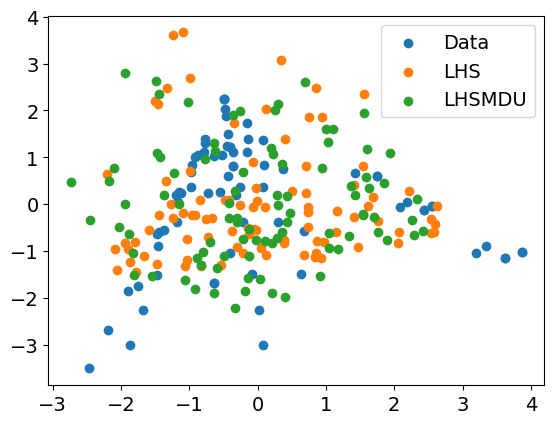

In [30]:
pca = PCA(n_components=2)
Xt1_pca = pca.fit_transform(data_scaled)
Xt2_pca = pca.fit_transform(all_val_samples_scaled)
Xt3_pca = pca.fit_transform(all_val_samples_mdu_scaled)
    
plot_dimred_2dims_both_methods(Xt1_pca, Xt2_pca, Xt3_pca, filename_eps='Figures_9dim/plot_scaled_90pts.eps')

### Pairwise scatter and distribution plots

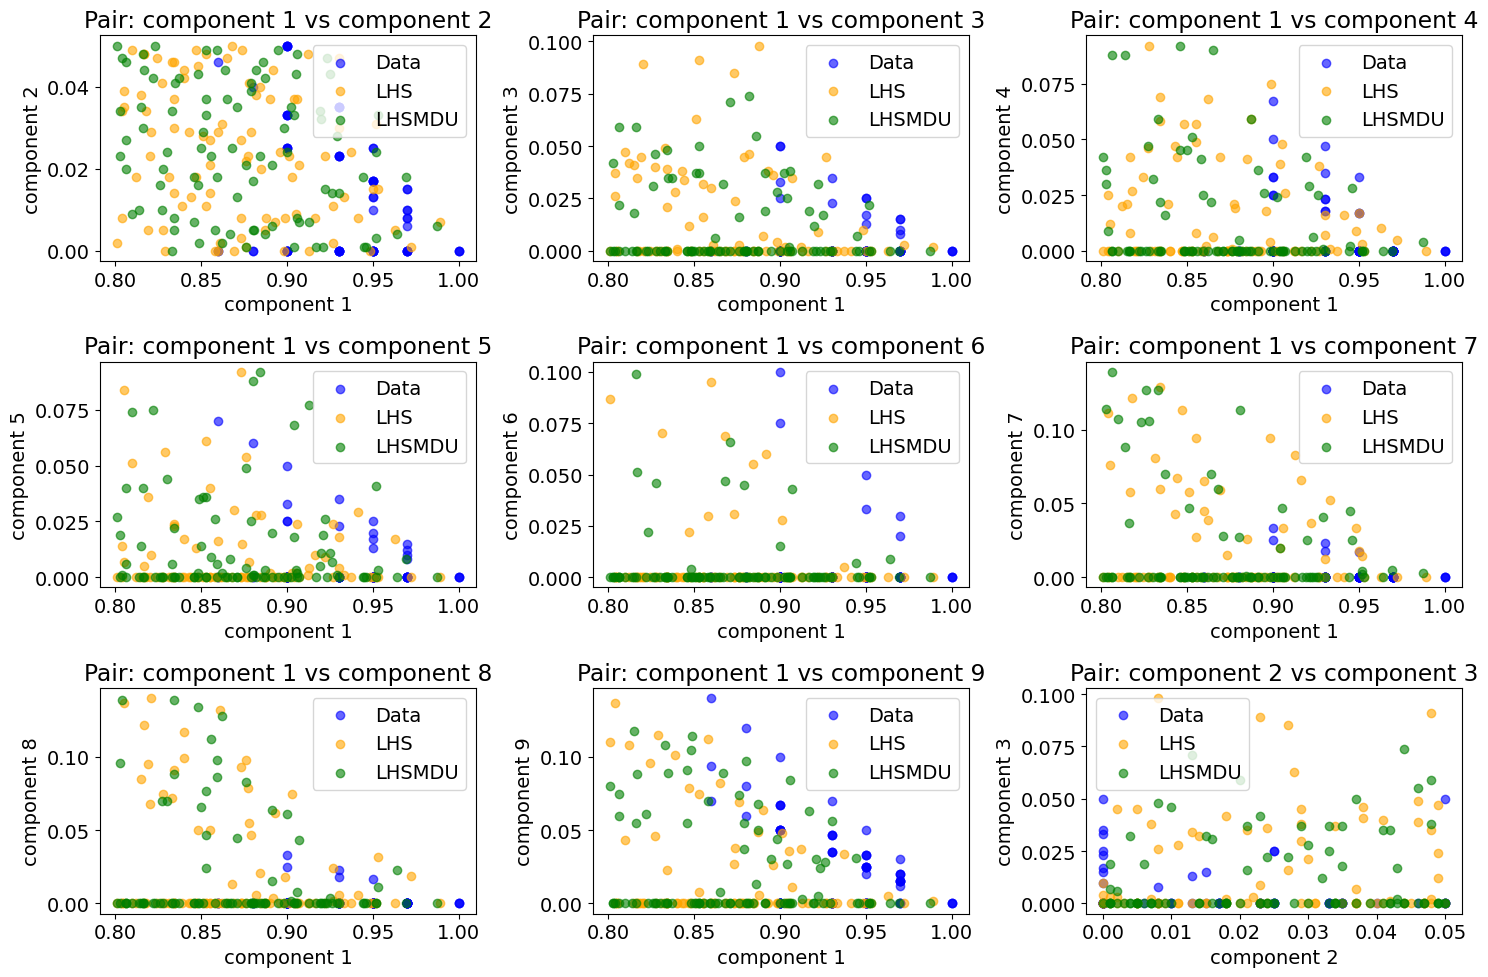

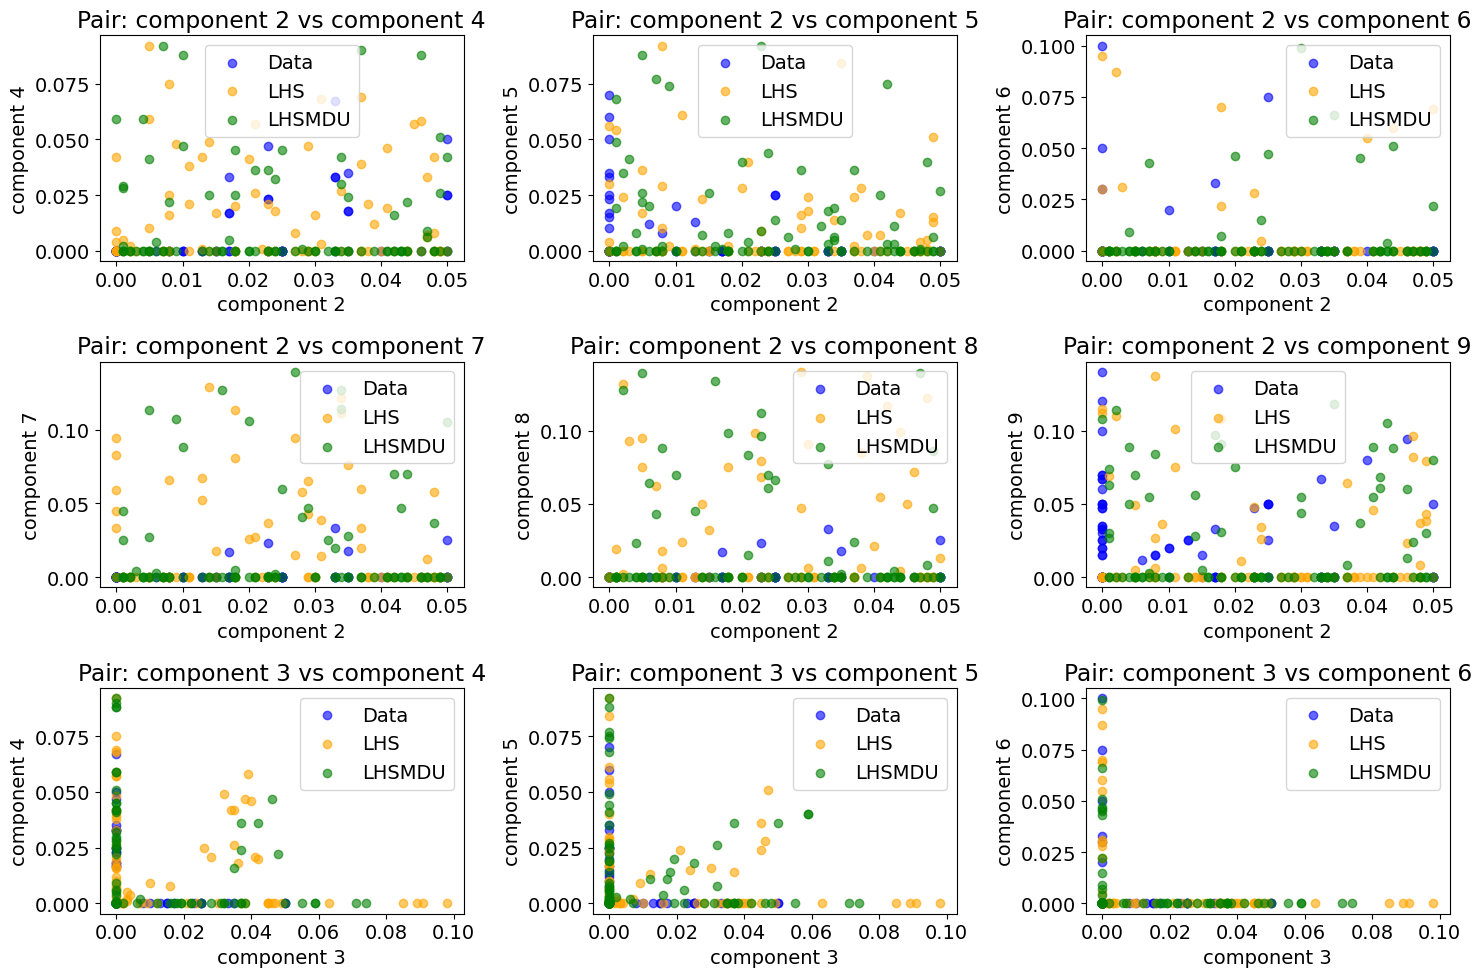

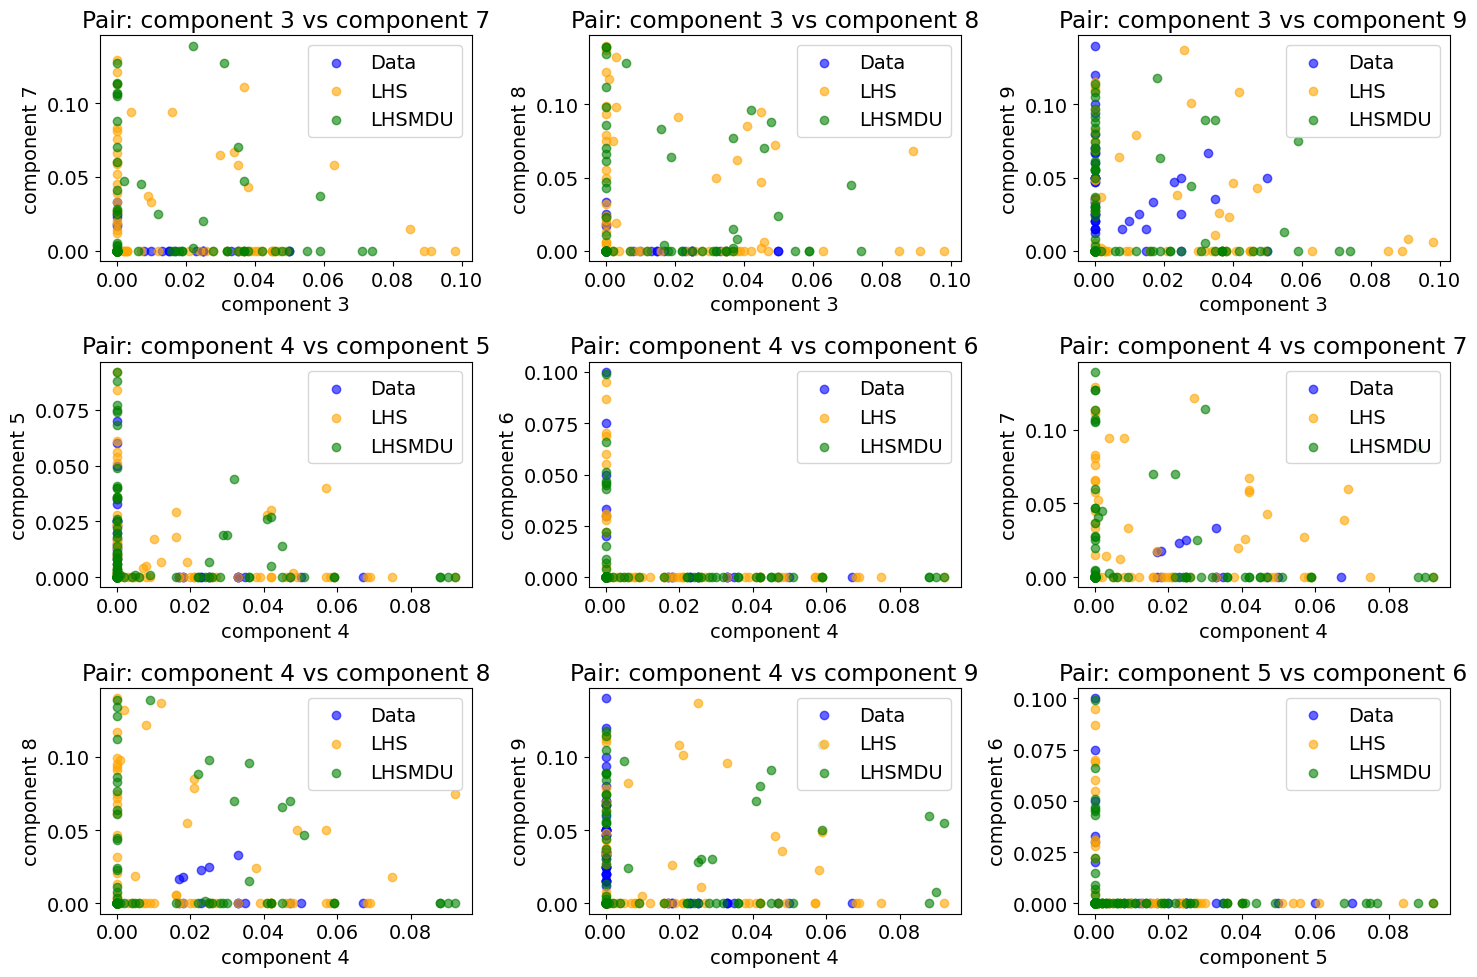

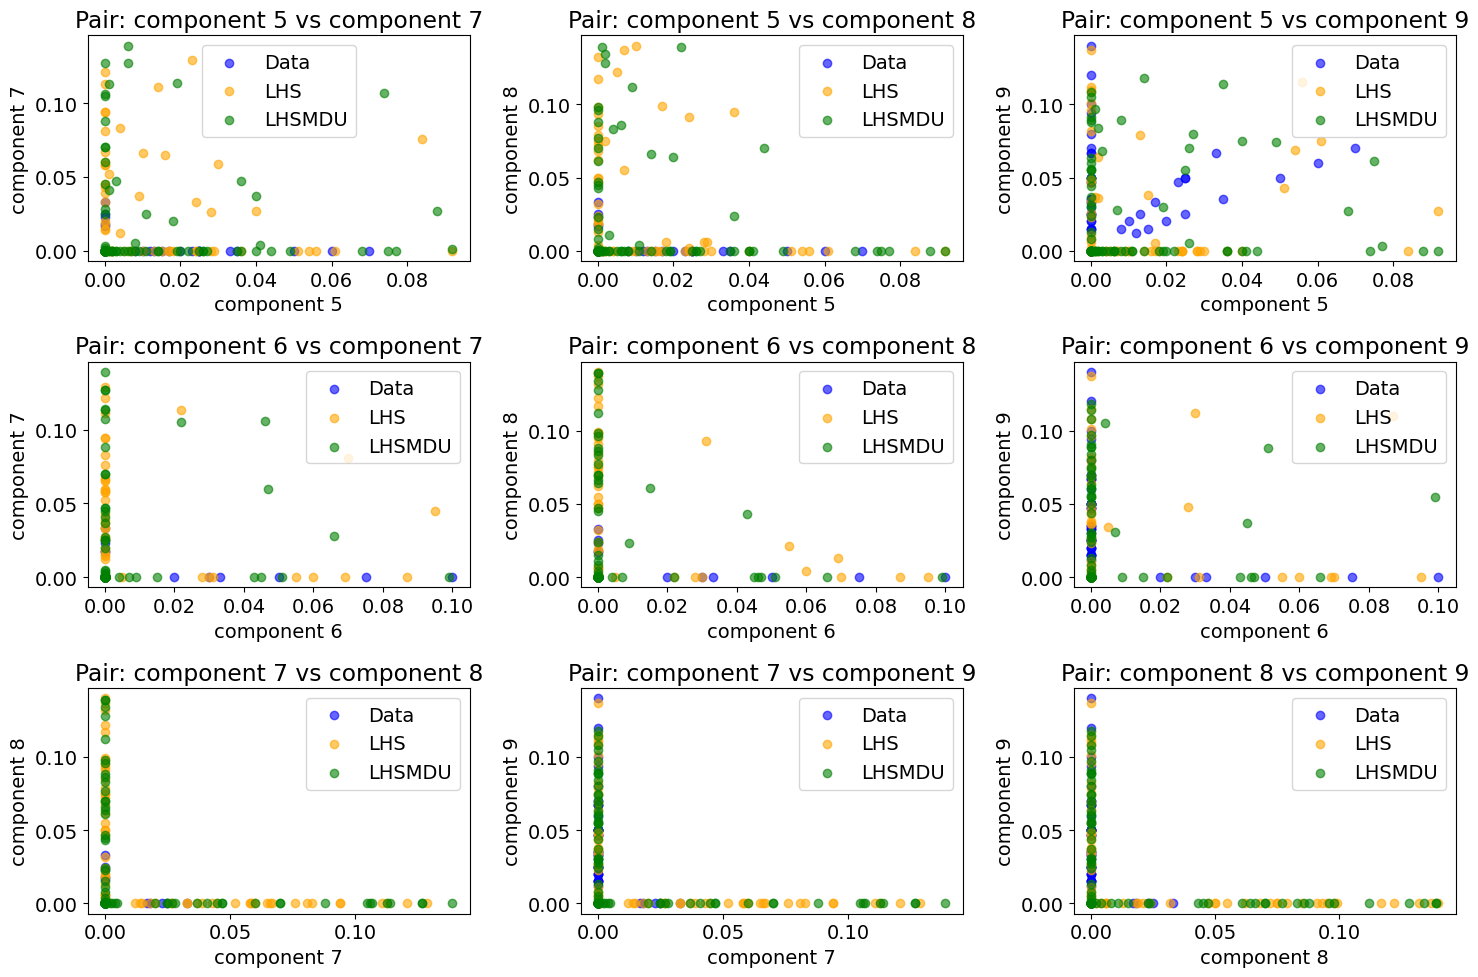

In [31]:

#dim_labels = ['component 1', 'component 2', 'component 3', 'component 4']
create_pairwise_scatterplots(
    data=data_array,
    lhs=np.array(df_all),
    lhsmdu=np.array(df_all_lhsmdu)#,
    #filename_eps='Figures_9dim/pairwiseplot_unscaled_90pts.eps'
)

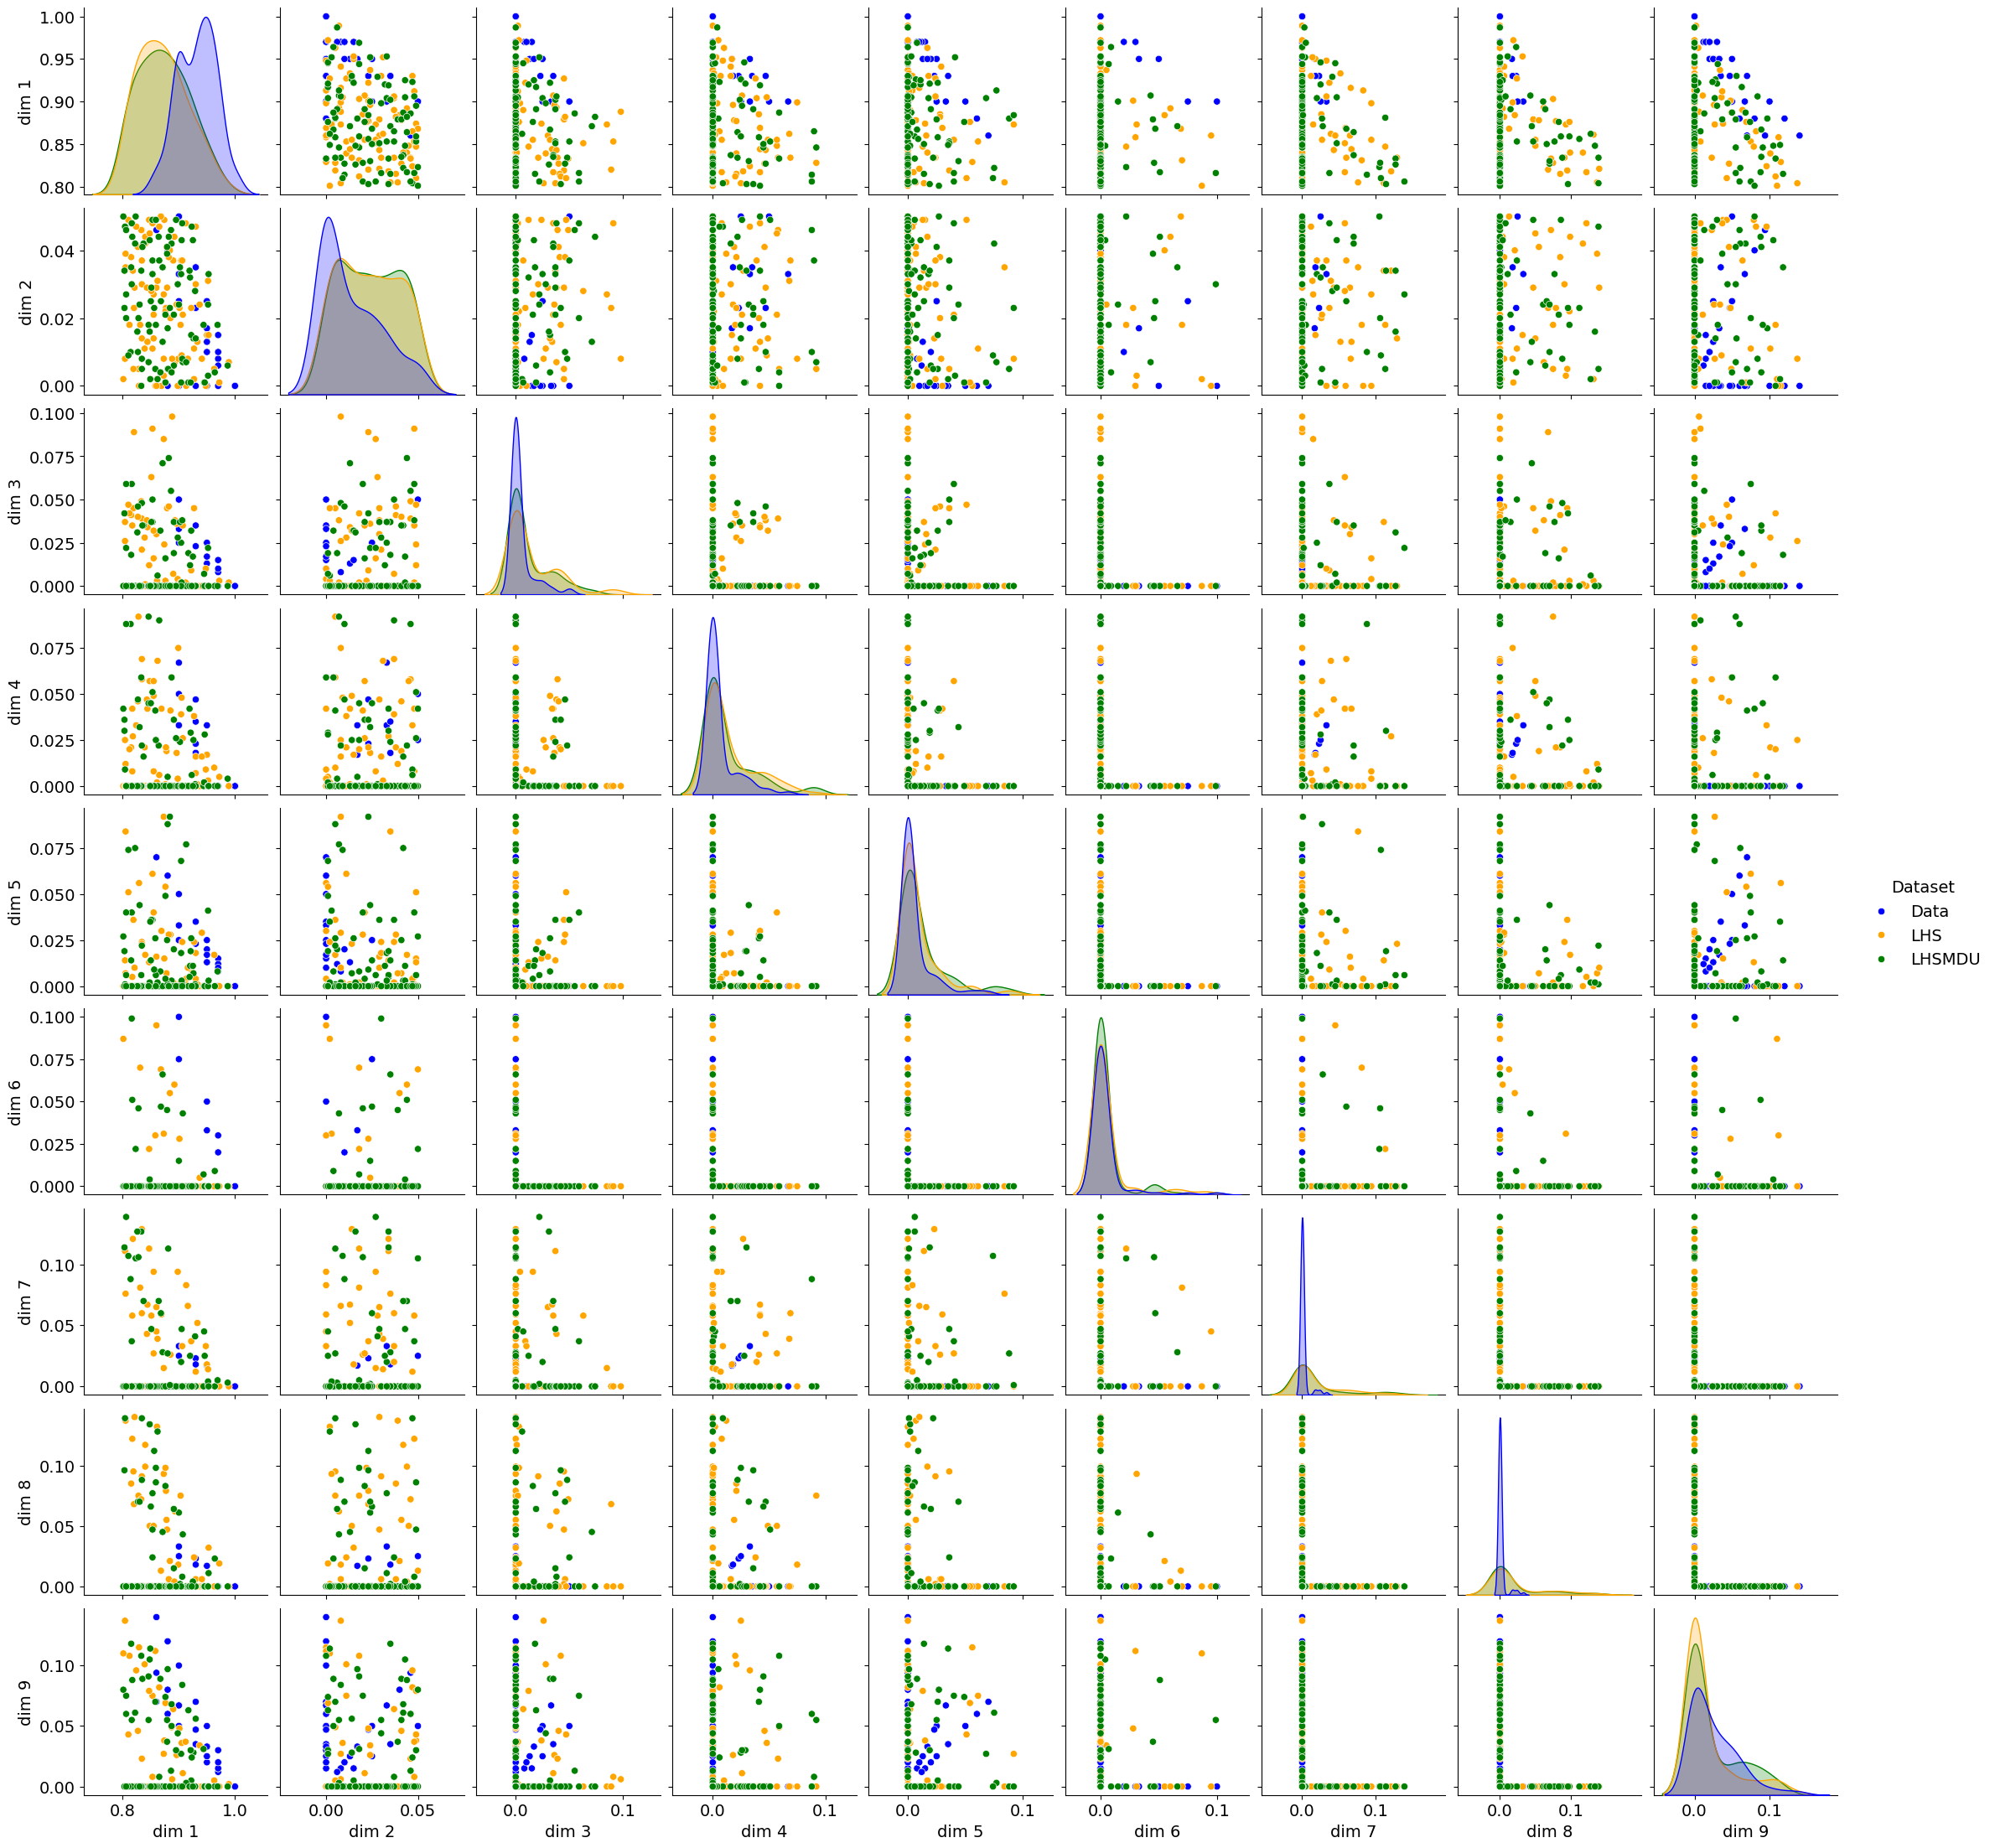

In [32]:
create_pairwise_distribution_plots_seaborn(data_array, np.array(df_all), np.array(df_all_lhsmdu), filename_eps="Figures_9dim/pairwise_distributions_90pts_9dim.png")


In [33]:
tol = 5e-1
tol2 = 5e-1
des_n_samp = 15

tol_samples, tol_samples_LHSMDU, tol_samples_unscaled, tol_samples_LHSMDU_unscaled = select_samples_diff_from_data(exp_data=data_array, samples_LHS=df_all.to_numpy(), samples_LHSMDU=df_all_lhsmdu.to_numpy(), des_n_samp = des_n_samp, tol = tol, tol2 = tol2)


In [34]:
df_15_samps_scaled = pd.DataFrame(tol_samples,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])
df_15_samps = pd.DataFrame(tol_samples_unscaled,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])

#### Check if add up to 100%

In [35]:
df_perc = df_15_samps*100
for i in range(len(df_perc)):
    if abs(sum(df_perc.iloc[i,:])-100)>1e-2:
        print(sum(df_perc.iloc[i,:]))

In [36]:
df_perc

PA-56  PhA  Mel  THAM   CS   BN  ZnBO  CaBO   HNT
0    84.4  1.3  3.4   4.2  0.0  0.0   6.7   0.0   0.0
1    91.3  0.0  0.0   0.0  0.4  0.0   8.3   0.0   0.0
2    85.5  2.1  0.0   5.7  4.0  0.0   2.7   0.0   0.0
3    81.5  3.8  4.1   2.1  0.0  0.0   0.0   8.5   0.0
4    81.7  4.8  3.5   4.2  0.0  0.0   5.8   0.0   0.0
5    86.9  0.0  0.0   4.2  3.0  0.0   5.9   0.0   0.0
6    87.3  0.3  0.0   0.0  0.0  3.1   0.0   9.3   0.0
7    83.4  1.4  0.0   0.0  2.3  0.0  12.9   0.0   0.0
8    83.4  3.0  2.1   0.0  2.4  0.0   0.0   9.1   0.0
9    83.1  1.8  0.0   0.0  0.0  7.0   8.1   0.0   0.0
10   82.8  0.5  0.0   9.2  0.0  0.0   0.0   7.5   0.0
11   80.4  3.4  3.7   0.0  1.4  0.0  11.1   0.0   0.0
12   80.5  3.5  0.0   0.0  8.4  0.0   7.6   0.0   0.0
13   81.9  0.5  4.5   0.0  3.6  0.0   0.0   9.5   0.0
14   80.1  0.2  0.0   0.0  0.0  8.7   0.0   0.0  11.0

In [37]:
filepath = Path('Outputs/postprocessed_outputs_15lhs_9dim.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_perc.to_csv(filepath, float_format='%.1f') 

### **6. Calculate other discrepancies and variance to check space filling properties/uniformity**

In [38]:
space = qmc.scale(df_15_samps, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

4.46570241196684

In [39]:
qmc.discrepancy(space, method='WD')

6.549966617223772

In [40]:
np.linalg.norm(space.var())

np.float64(0.07191565773634555)

In [41]:
df_data = df[['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT']].copy()
df_data = df_data
df_with_data = pd.concat([df_15_samps, df_data], ignore_index=True, axis=0)

In [42]:
df_with_data

PA-56    PhA    Mel   THAM     CS   BN   ZnBO   CaBO    HNT
0   0.844  0.013  0.034  0.042  0.000  0.0  0.067  0.000  0.000
1   0.913  0.000  0.000  0.000  0.004  0.0  0.083  0.000  0.000
2   0.855  0.021  0.000  0.057  0.040  0.0  0.027  0.000  0.000
3   0.815  0.038  0.041  0.021  0.000  0.0  0.000  0.085  0.000
4   0.817  0.048  0.035  0.042  0.000  0.0  0.058  0.000  0.000
..    ...    ...    ...    ...    ...  ...    ...    ...    ...
85  0.900  0.000  0.050  0.000  0.000  0.0  0.000  0.000  0.050
86  0.970  0.000  0.010  0.000  0.000  0.0  0.000  0.000  0.020
87  0.950  0.000  0.017  0.000  0.000  0.0  0.000  0.000  0.033
88  0.930  0.000  0.023  0.000  0.000  0.0  0.000  0.000  0.047
89  0.900  0.000  0.033  0.000  0.000  0.0  0.000  0.000  0.067

[90 rows x 9 columns]

In [43]:
space = qmc.scale(df_with_data, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

8.863653809909232

In [44]:
qmc.discrepancy(space, method='WD')

9.589495582333234

In [45]:
np.linalg.norm(space.var())

np.float64(0.06926219590405892)

In [46]:
df_15_samps_lhsmdu = pd.DataFrame(tol_samples_LHSMDU_unscaled,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])
df_15_samps_lhsmdu_scaled = pd.DataFrame(tol_samples_LHSMDU,columns=['PA-56','PhA','Mel','THAM','CS','BN','ZnBO','CaBO','HNT'])

In [47]:
space = qmc.scale(df_15_samps_lhsmdu, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

4.661555014052654

In [48]:
qmc.discrepancy(space, method='WD')

7.218189252929697

In [49]:
np.linalg.norm(space.var())

np.float64(0.07928633649673862)

#### Check if add up to 100%

In [50]:
df_perc_lhsmdu = df_15_samps_lhsmdu*100
for i in range(len(df_perc_lhsmdu)):
    if abs(sum(df_perc_lhsmdu.iloc[i,:])-100)>1e-2:
        print(sum(df_perc_lhsmdu.iloc[i,:]))

In [51]:
df_perc_lhsmdu

PA-56  PhA  Mel  THAM   CS   BN  ZnBO  CaBO   HNT
0    83.7  4.2  3.5   1.6  0.0  0.0   7.0   0.0   0.0
1    84.6  0.7  0.0   9.2  0.0  0.0   0.0   0.0   5.5
2    80.6  2.7  2.2   0.0  0.6  0.0  13.9   0.0   0.0
3    83.3  0.0  0.0   5.9  0.0  0.0   0.0   0.0  10.8
4    81.6  4.8  5.9   0.0  4.0  0.0   3.7   0.0   0.0
5    83.0  2.4  0.0   3.2  4.4  0.0   0.0   7.0   0.0
6    83.4  0.5  0.0   0.0  2.2  0.0   0.0  13.9   0.0
7    82.6  1.6  3.1   0.0  0.0  0.0  12.7   0.0   0.0
8    83.4  0.8  4.8   2.2  0.0  0.0   0.0   8.8   0.0
9    80.3  2.3  4.2   3.6  0.0  0.0   0.0   9.6   0.0
10   81.4  1.0  0.0   8.8  0.0  0.0   8.8   0.0   0.0
11   82.7  1.0  4.6   4.7  0.0  0.0   0.0   7.0   0.0
12   81.0  0.9  0.0   0.0  7.4  0.0  10.7   0.0   0.0
13   81.7  4.4  0.0   0.0  0.0  5.1   0.0   0.0   8.8
14   82.8  2.0  0.0   0.0  0.0  4.6  10.6   0.0   0.0

In [52]:
filepath = Path('Outputs/postprocessed_outputs_15lhsmdu_9dim.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_perc_lhsmdu.to_csv(filepath, float_format='%.1f') 

In [53]:
df_lhsmdu_with_data = pd.concat([df_15_samps_lhsmdu, df_data], ignore_index=True, axis=0)

In [54]:
space = qmc.scale(df_lhsmdu_with_data, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)#default CD

8.804822826208639

In [55]:
qmc.discrepancy(space, method='WD')

9.711441192984948

In [56]:
np.linalg.norm(space.var())

np.float64(0.07056512542030986)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


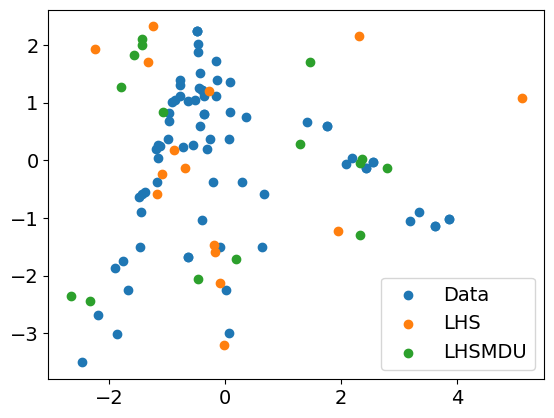

In [57]:
pca = PCA(n_components=2)
Xt1_pca = pca.fit_transform(data_scaled)
Xt2_pca = pca.fit_transform(df_15_samps_scaled)
Xt3_pca = pca.fit_transform(df_15_samps_lhsmdu_scaled)
    
plot_dimred_2dims_both_methods(Xt1_pca, Xt2_pca, Xt3_pca, filename_eps='Figures_9dim/plot_scaled_15pts.eps')

### Pairwise scatter plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


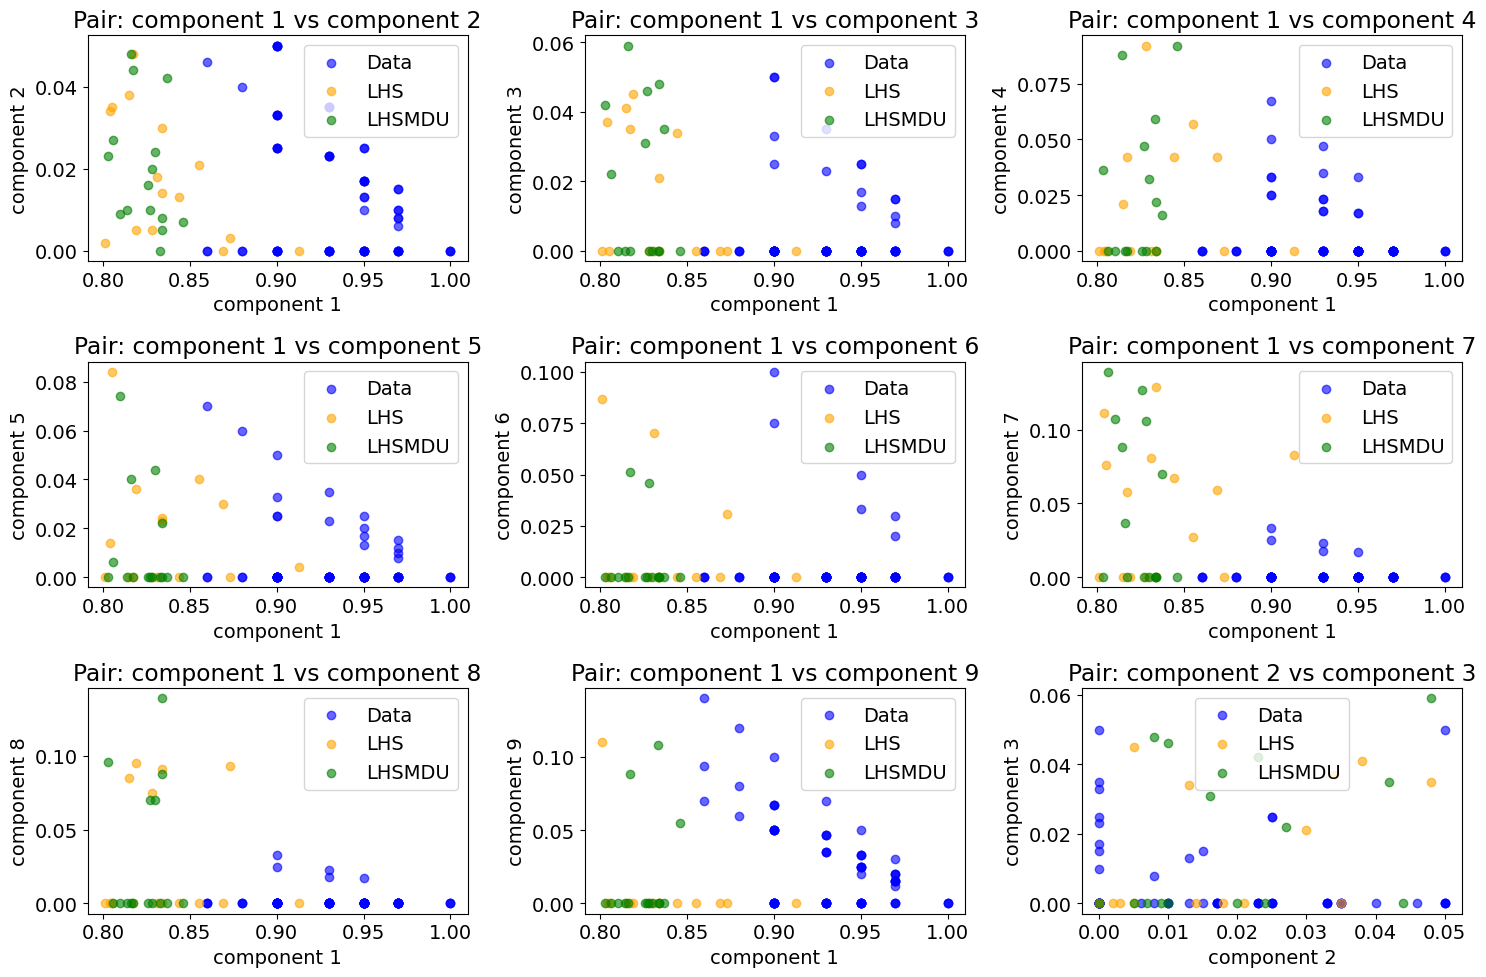

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


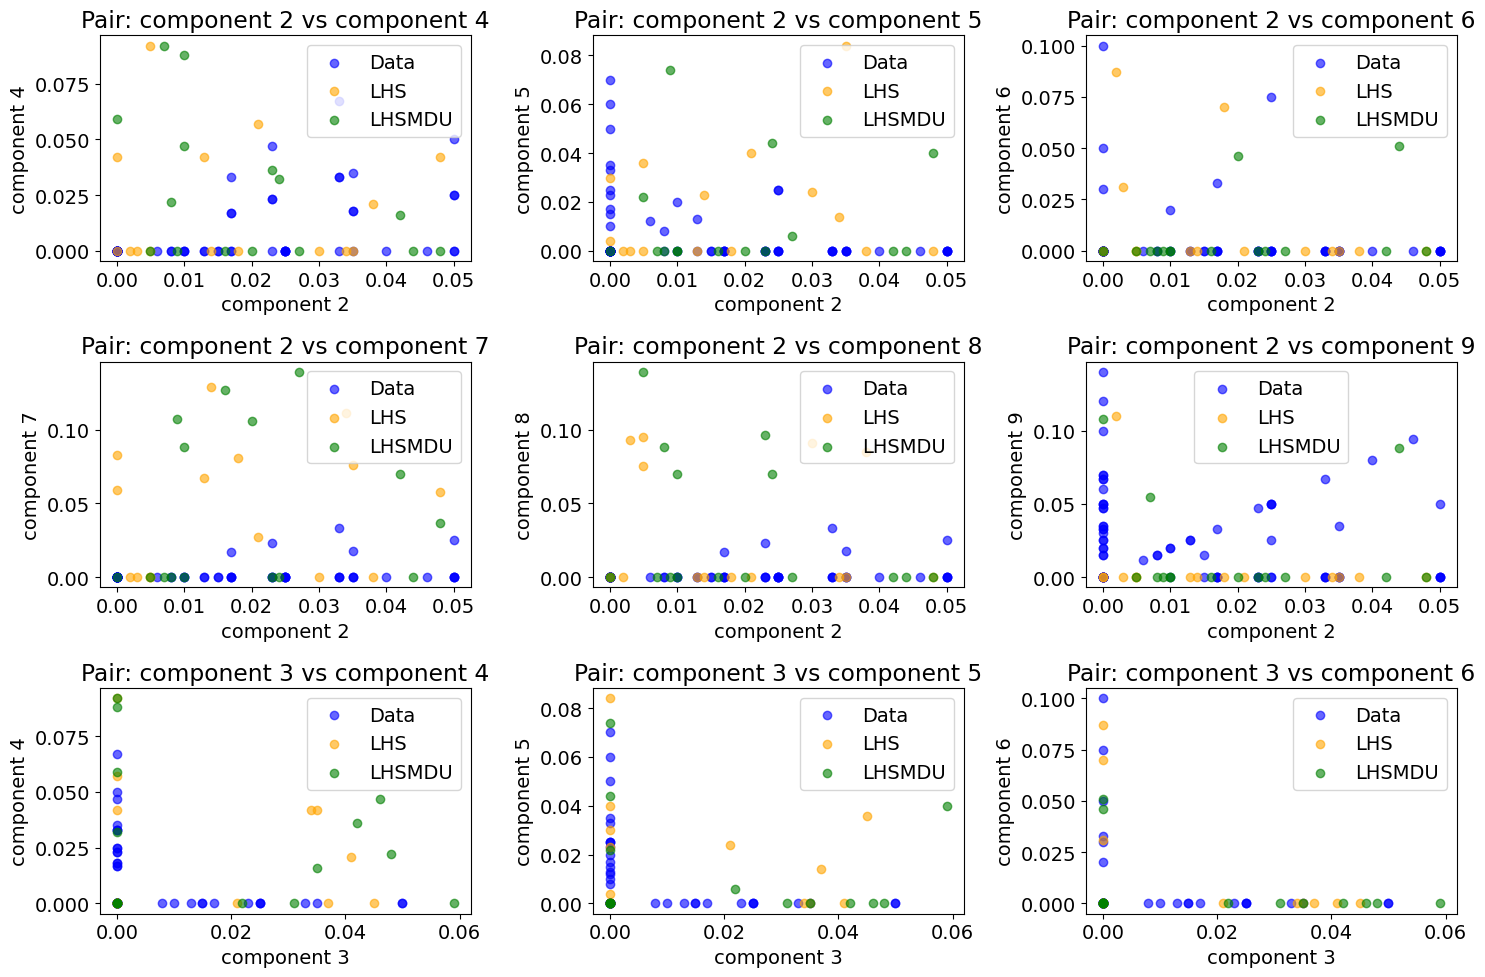

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


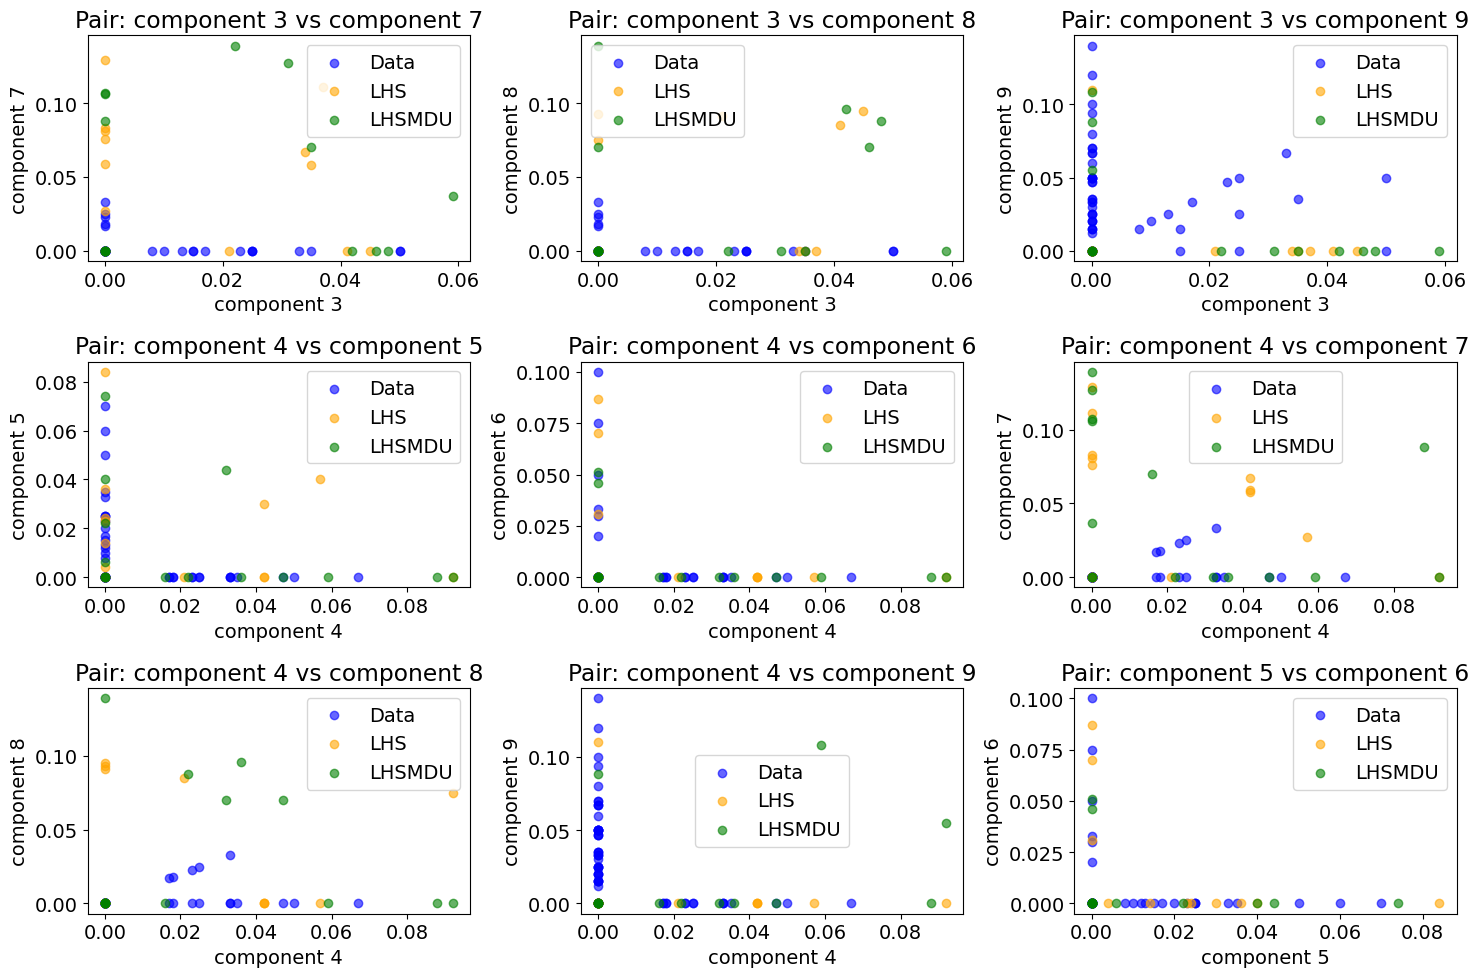

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


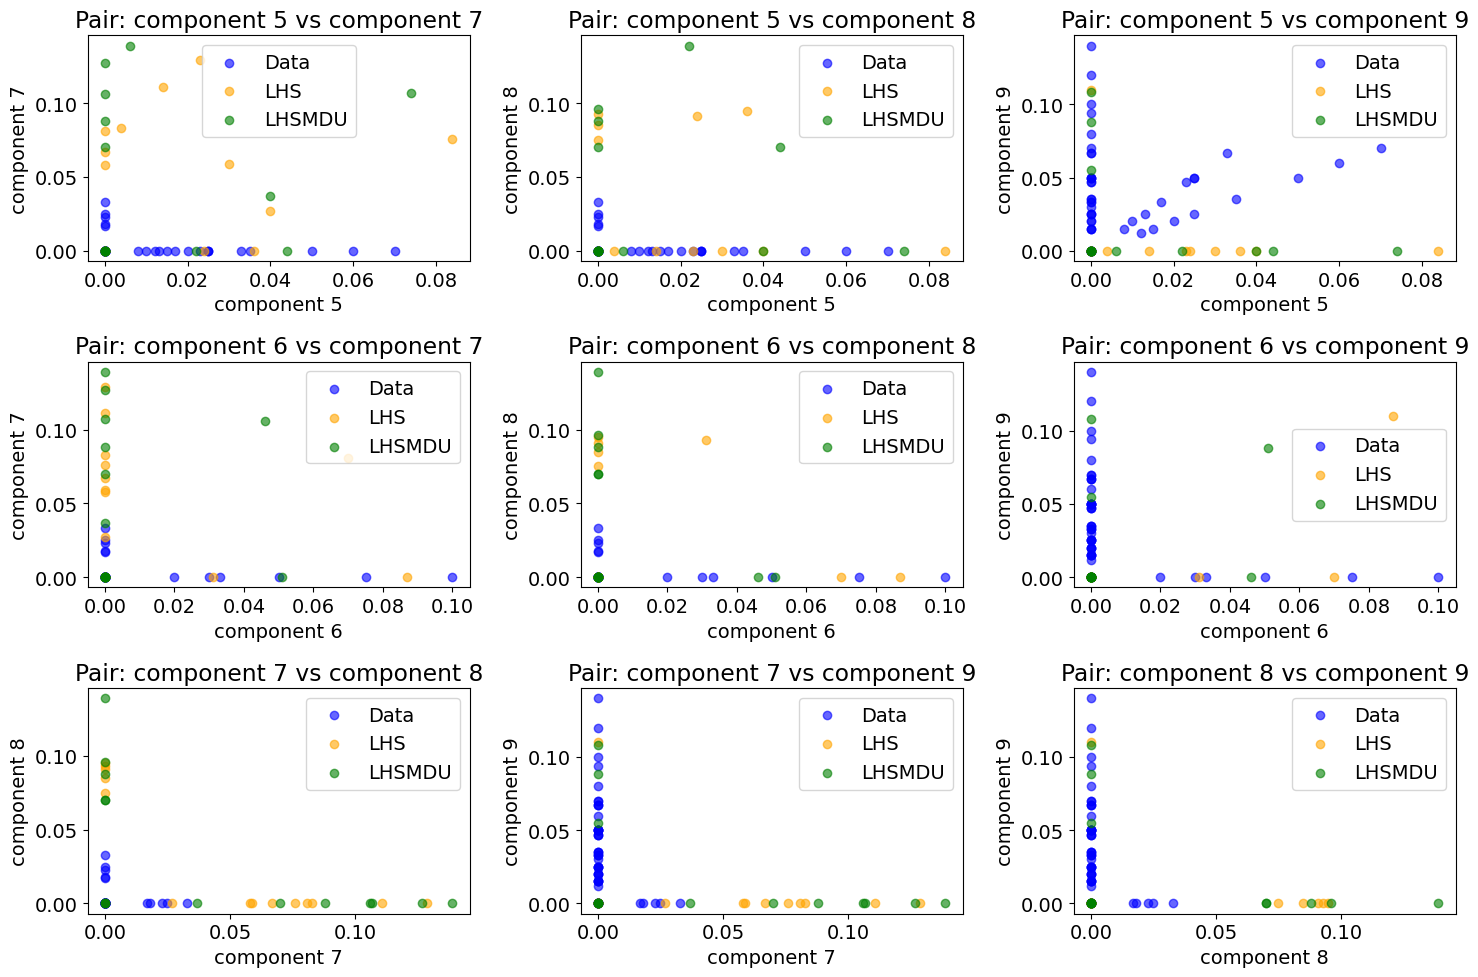

In [58]:
create_pairwise_scatterplots(
    data=data_array,
    lhs=np.array(df_15_samps),
    lhsmdu=np.array(df_15_samps_lhsmdu),
    filename_eps='Figures_9dim/pairwiseplot_unscaled_15pts.eps'
)

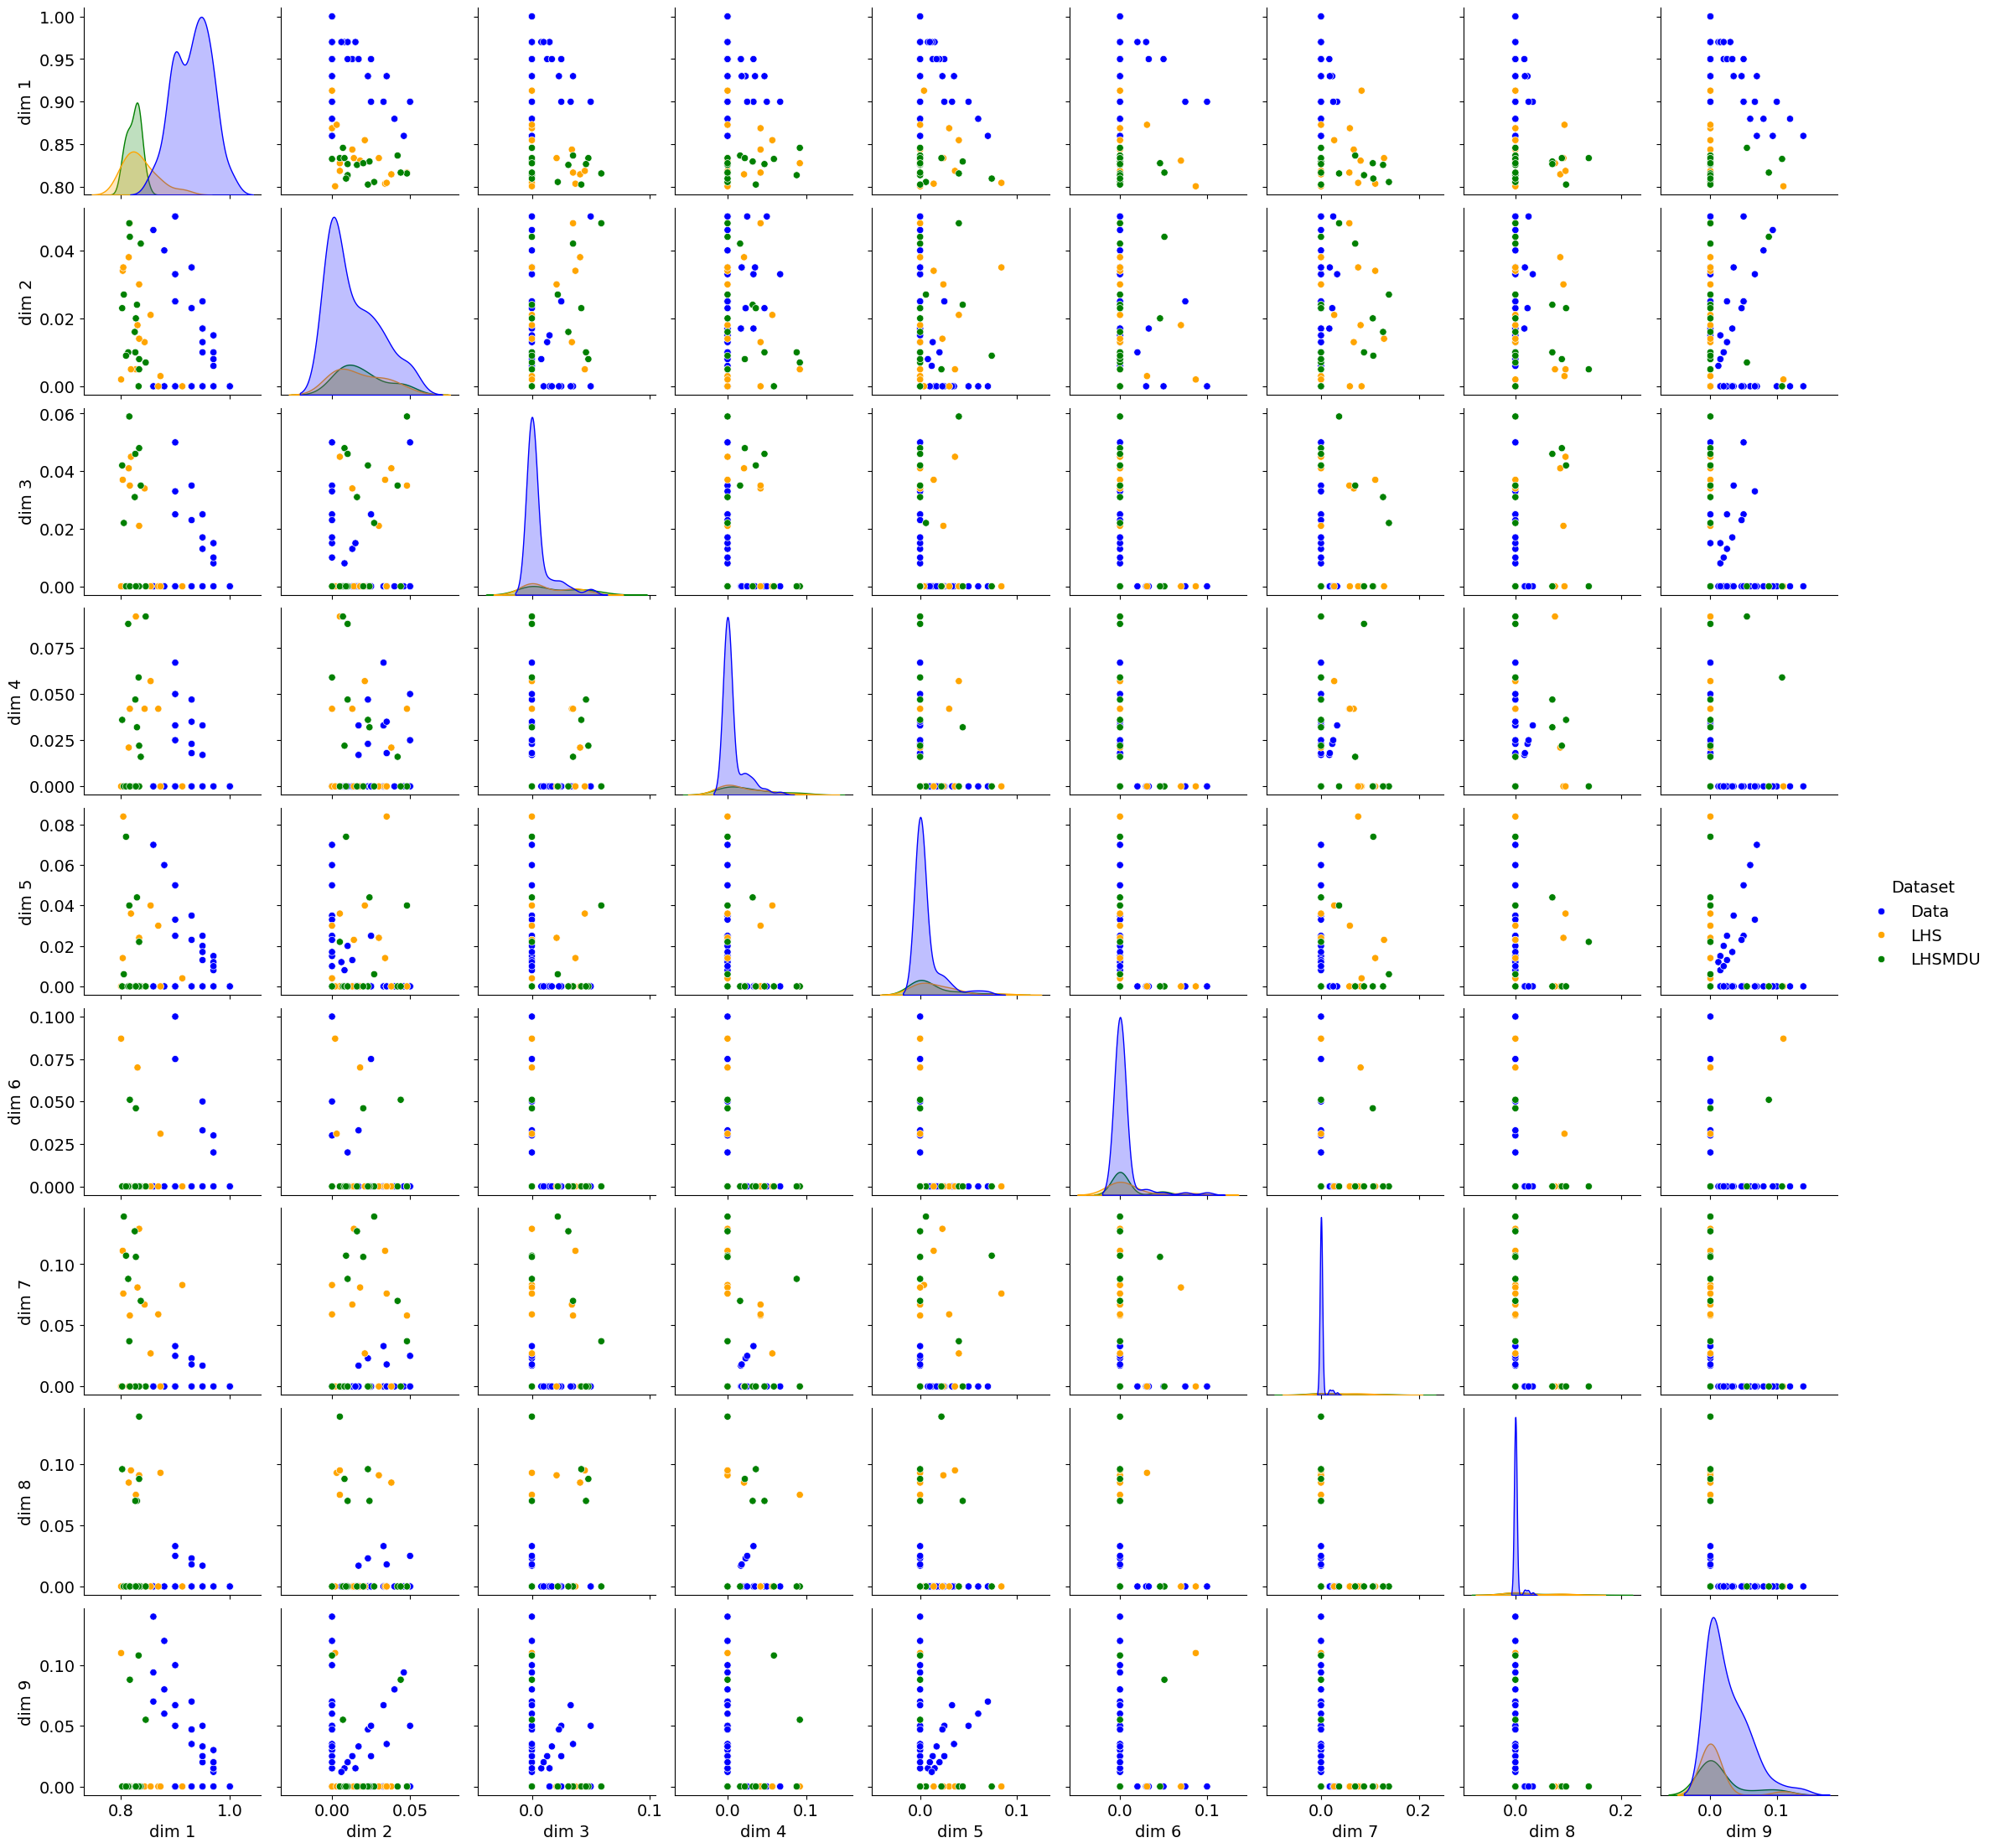

In [59]:
create_pairwise_distribution_plots_seaborn(data_array, np.array(df_15_samps), np.array(df_15_samps_lhsmdu), filename_eps="Figures_9dim/pairwise_distributions_15pts_9dim.png")


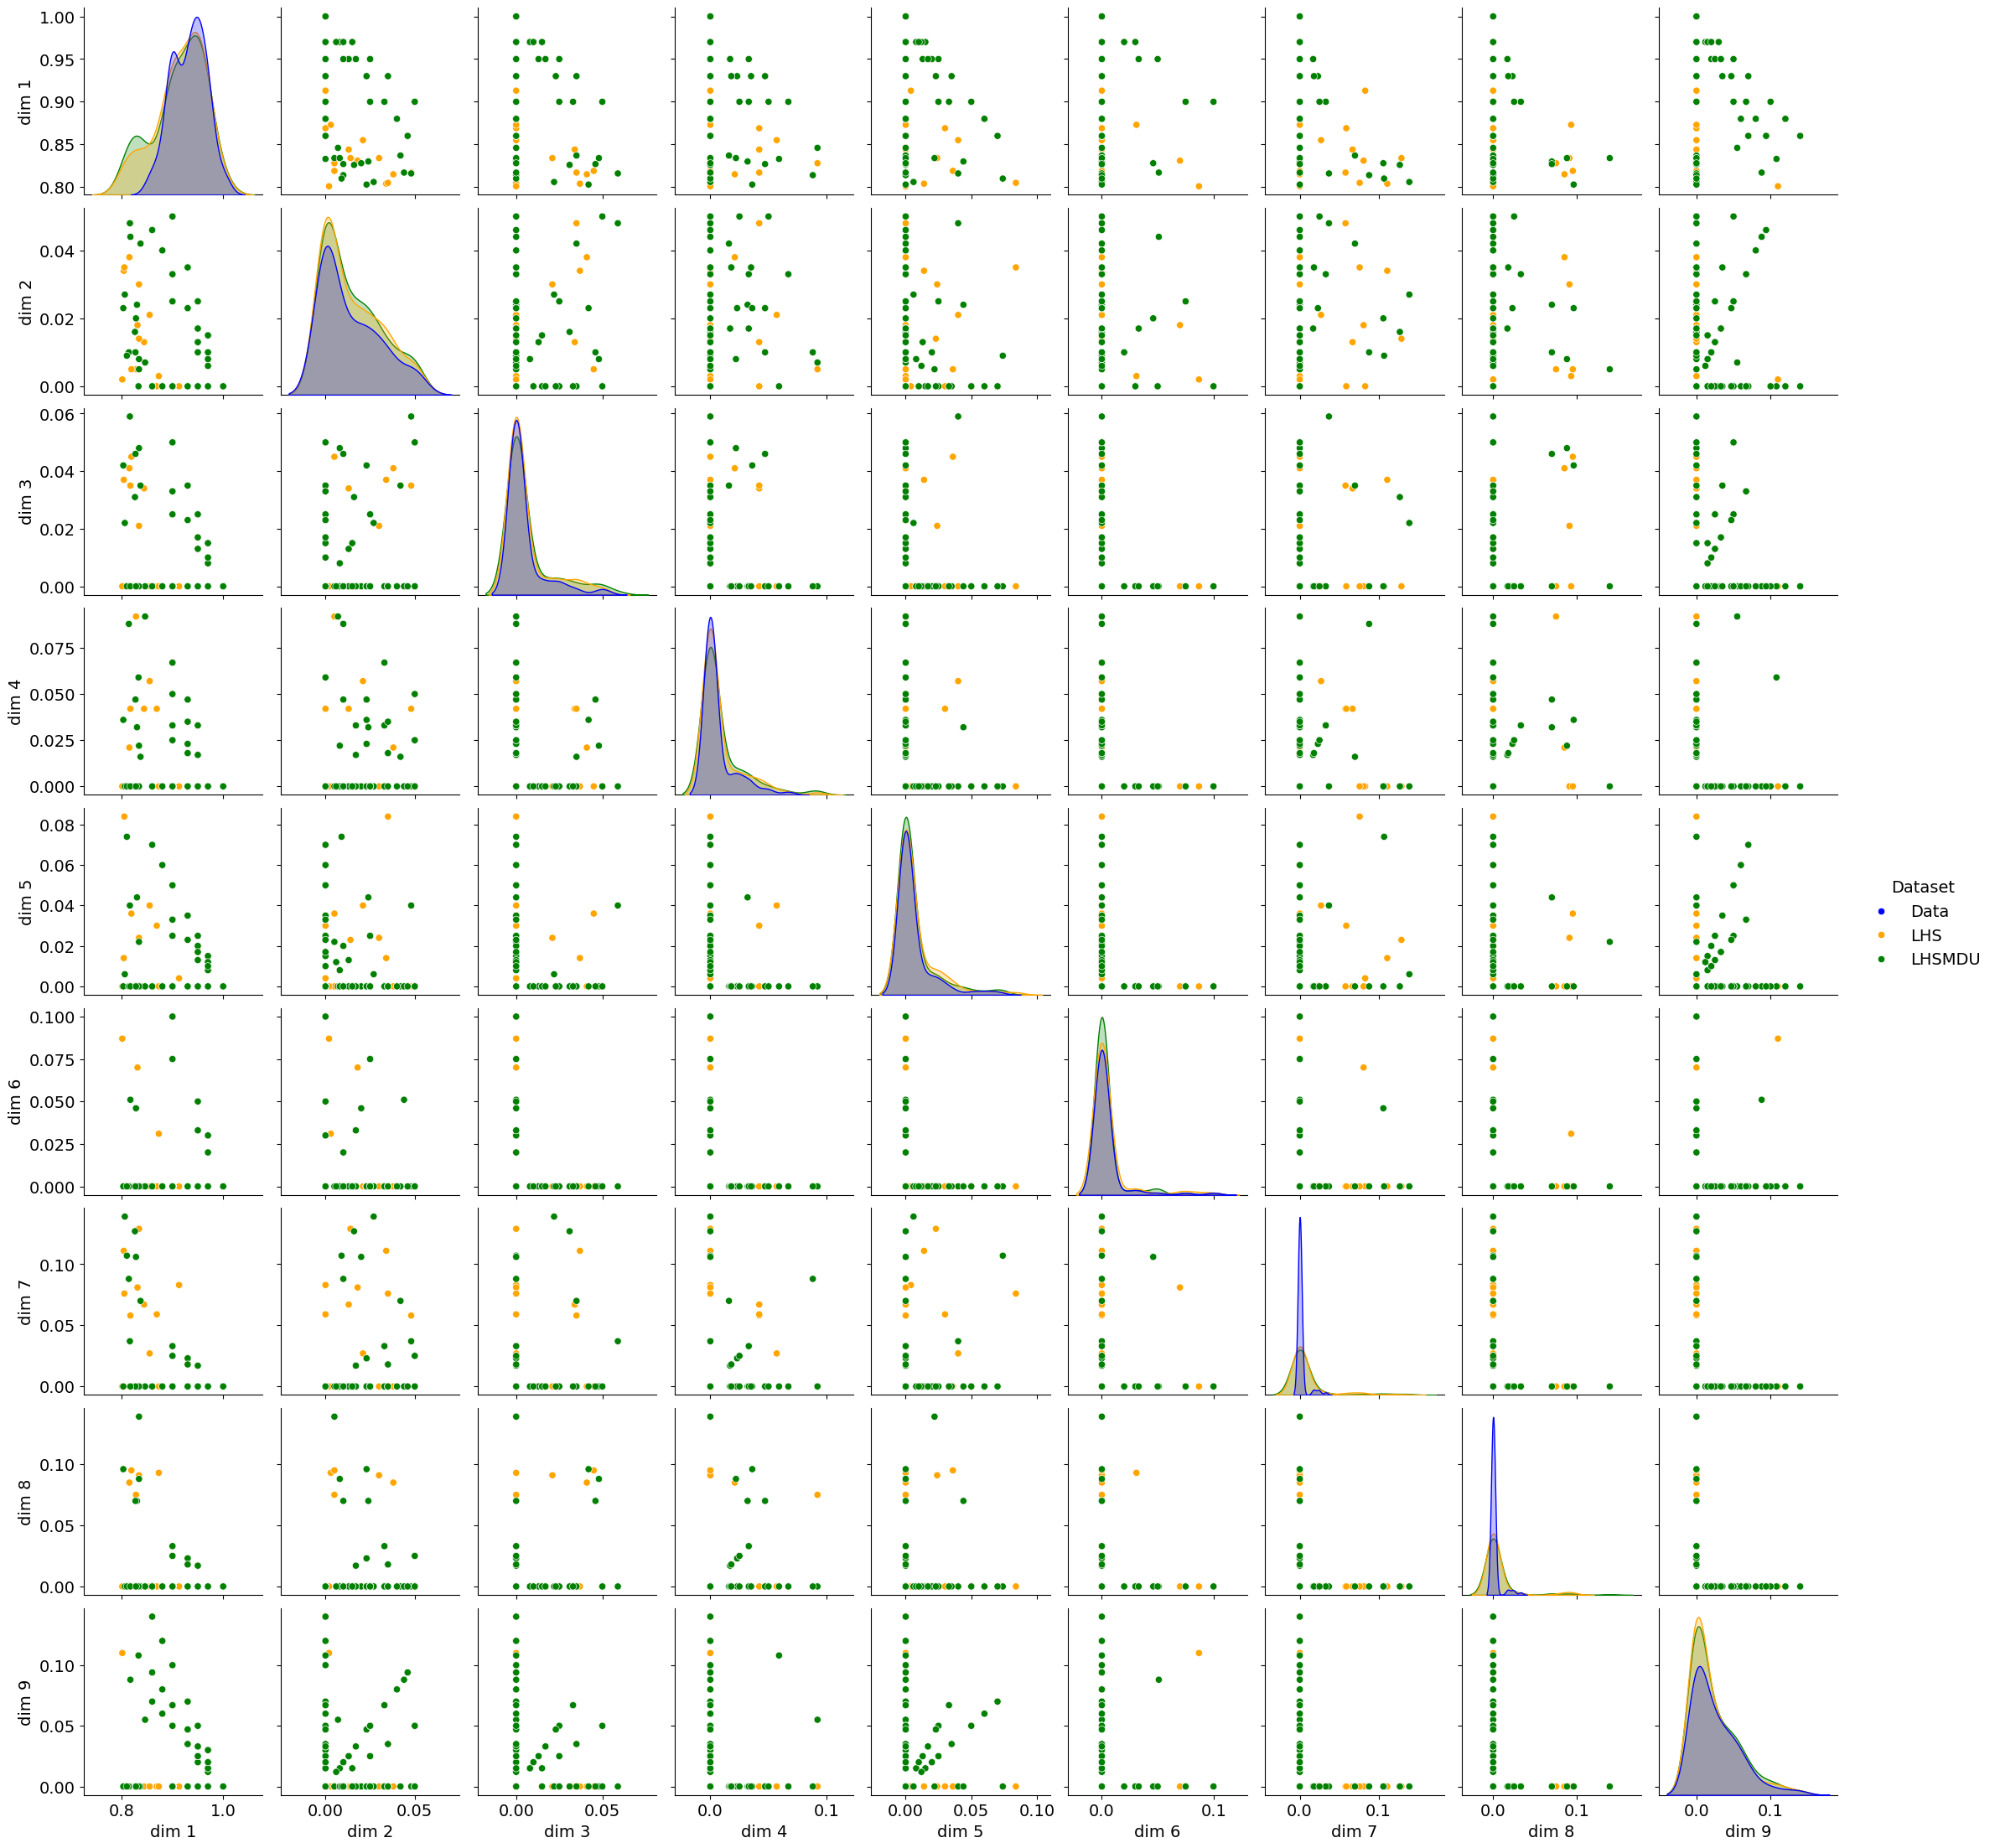

In [60]:
create_pairwise_distribution_plots_seaborn(data_array, np.array(df_with_data), np.array(df_lhsmdu_with_data), filename_eps="Figures_9dim/pairwise_distributions_15ptsplusdata_9dim.png")


### **7. Distribution plots**

In [61]:
df_perc_lhsmdu = df_15_samps_lhsmdu*100
for i in range(len(df_perc_lhsmdu)):
    if abs(sum(df_perc_lhsmdu.iloc[i,:])-100)>1e-2:
        print(sum(df_perc_lhsmdu.iloc[i,:]))

In [62]:
df_perc_lhsmdu

PA-56  PhA  Mel  THAM   CS   BN  ZnBO  CaBO   HNT
0    83.7  4.2  3.5   1.6  0.0  0.0   7.0   0.0   0.0
1    84.6  0.7  0.0   9.2  0.0  0.0   0.0   0.0   5.5
2    80.6  2.7  2.2   0.0  0.6  0.0  13.9   0.0   0.0
3    83.3  0.0  0.0   5.9  0.0  0.0   0.0   0.0  10.8
4    81.6  4.8  5.9   0.0  4.0  0.0   3.7   0.0   0.0
5    83.0  2.4  0.0   3.2  4.4  0.0   0.0   7.0   0.0
6    83.4  0.5  0.0   0.0  2.2  0.0   0.0  13.9   0.0
7    82.6  1.6  3.1   0.0  0.0  0.0  12.7   0.0   0.0
8    83.4  0.8  4.8   2.2  0.0  0.0   0.0   8.8   0.0
9    80.3  2.3  4.2   3.6  0.0  0.0   0.0   9.6   0.0
10   81.4  1.0  0.0   8.8  0.0  0.0   8.8   0.0   0.0
11   82.7  1.0  4.6   4.7  0.0  0.0   0.0   7.0   0.0
12   81.0  0.9  0.0   0.0  7.4  0.0  10.7   0.0   0.0
13   81.7  4.4  0.0   0.0  0.0  5.1   0.0   0.0   8.8
14   82.8  2.0  0.0   0.0  0.0  4.6  10.6   0.0   0.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


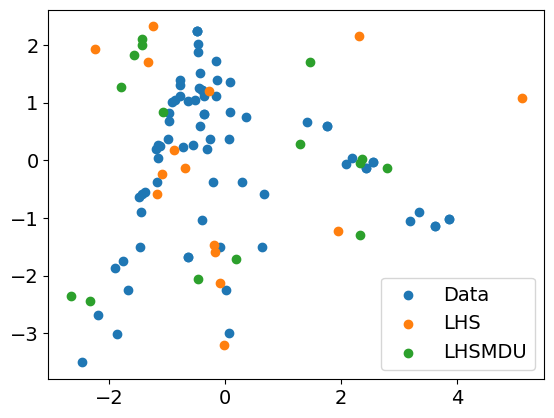

In [63]:
def plot_dimred_2dims_both_methods(Xt1, Xt2_new, Xt3_new):
    pca = PCA(n_components=2)
    Xt1_pca = pca.fit_transform(Xt1)
    Xt2_pca = pca.fit_transform(Xt2_new)
    Xt3_pca = pca.fit_transform(Xt3_new)
    plt.scatter(Xt1_pca[:,0], Xt1_pca[:,1])
    plt.scatter(Xt2_pca[:,0], Xt2_pca[:,1])
    plt.scatter(Xt3_pca[:,0], Xt3_pca[:,1])
    plt.legend(['Data', 'LHS', 'LHSMDU'])
    plt.savefig('Figures_9dim/plot_scaled_15pts.eps', format='eps')
    plt.show()
    
plot_dimred_2dims_both_methods(data_scaled, df_15_samps_scaled, df_15_samps_lhsmdu_scaled)

#### Distribution subplots of unscaled data

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


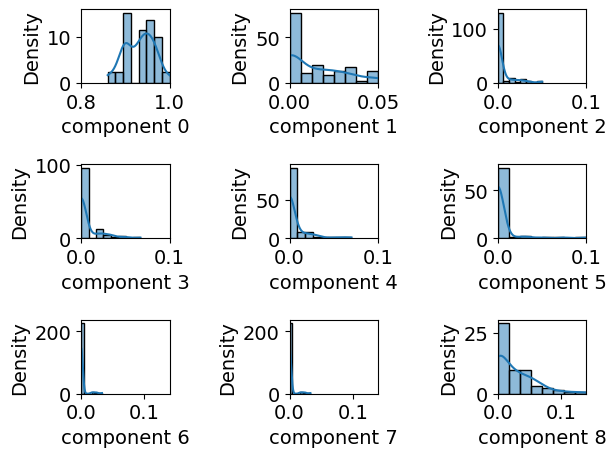

In [64]:
bounds = [[lb, ub] for lb, ub in zip(l_bounds, u_bounds)]
box_kdeplot_samples(data_array, filename_eps='Figures_9dim/dist_unscaled_expdata.eps', fixed_ranges=bounds)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


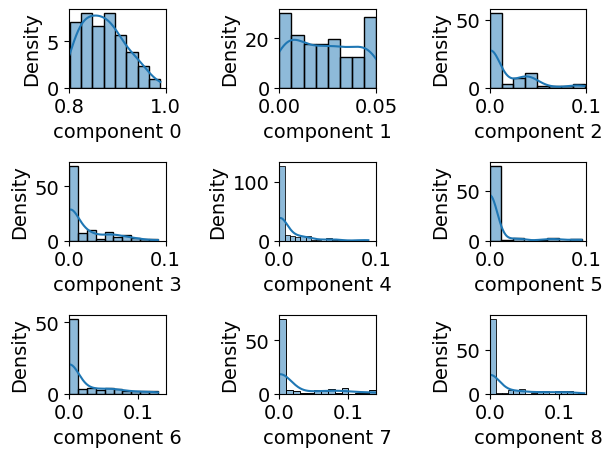

In [65]:
box_kdeplot_samples(df_all.to_numpy(), filename_eps='Figures_9dim/dist_unscaled_90ptsLHS.eps', fixed_ranges=bounds)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


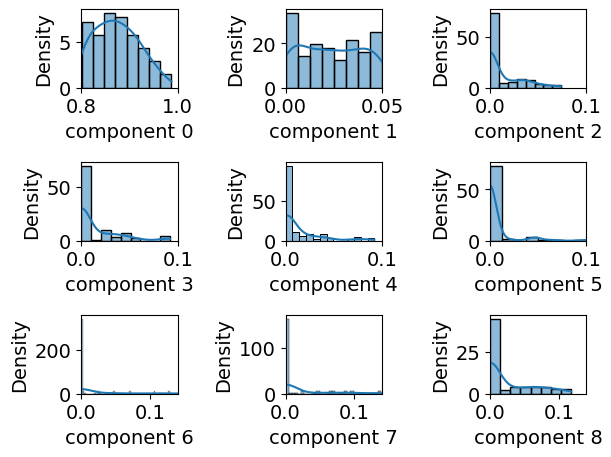

In [66]:
box_kdeplot_samples(df_all_lhsmdu.to_numpy(), filename_eps='Figures_9dim/dist_unscaled_90ptsLHSMDU.eps', fixed_ranges=bounds )

#### Distribution subplots of unscaled reduced data

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


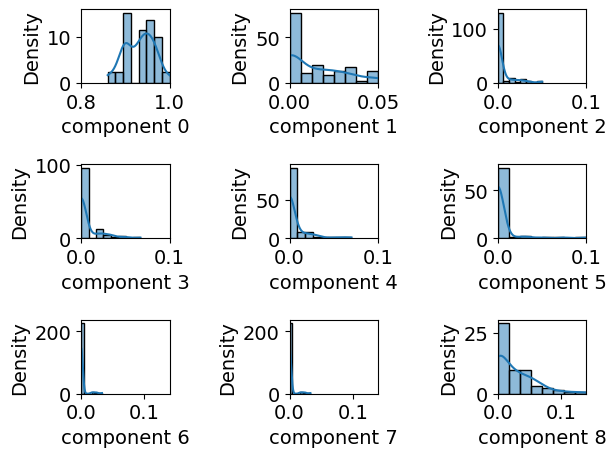

In [67]:
box_kdeplot_samples(data_array, filename_eps='Figures_9dim/dist_unscaled_expdata.eps', fixed_ranges=bounds)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


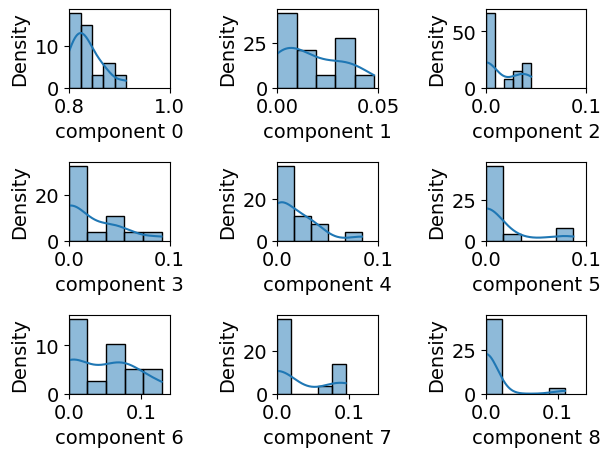

In [68]:
box_kdeplot_samples(tol_samples_unscaled, filename_eps='Figures_9dim/dist_unscaled_15ptsLHS.eps', fixed_ranges=bounds)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


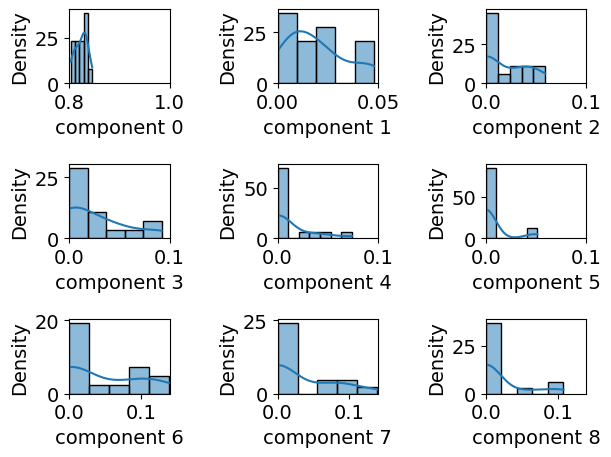

In [69]:
box_kdeplot_samples(tol_samples_LHSMDU_unscaled, filename_eps='Figures_9dim/dist_unscaled_15ptsLHSMDU.eps', fixed_ranges=bounds)